# SquareRoot Notebook
***Made by Phuong-Linh Nguyen (deLini1612)***

This notebook is used to test the mathematical aspect of the approx algorithm as well as validate the result

---

# Error and correction term

## Proposed terms by the paper

In [38]:
import numpy as np
from math import sqrt
import scipy.integrate as spi
import pandas as pd

# Define the Error function
def Em1(x, y):
    return (1+x+y)/((1+x)*(1+y)) - 1
def Em2(x, y):
    return (2*(x+y))/((1+x)*(1+y)) - 1

def Ed1(x, y):
    return ((1+x-y)*(1+y))/(1+x) - 1
def Ed2(x, y):
    return ((2+x-y)*(1+y))/(2*(1+x)) - 1

def Es(x):
    return (2**(x/2))/(sqrt(1+x)) - 1

def partial_correction_mul(E, x_lower_func, x_upper_func, y_lower, y_upper):
  """Computes the integral of - np.log2(1/(1-E)) over given limits for mul"""
  def integrand(x, y):
      return - np.log2(1/(1-E(x, y))) #Note: minus to obtain positive correction term

  try:
      result, _ = spi.dblquad(integrand, y_lower, y_upper, x_lower_func, x_upper_func)
      return result
  except Exception:
      return "Error"

def partial_correction_div(E, x_lower_func, x_upper_func, y_lower, y_upper):
  """Computes the integral of - np.log2(1/(1-E)) over given limits for div"""
  def integrand(x, y):
      return np.log2(1/(1-E(x, y)))

  try:
      result, _ = spi.dblquad(integrand, y_lower, y_upper, x_lower_func, x_upper_func)
      return result
  except Exception:
      return "Error"

def compute_correction_mul(x_lower, x_upper, y_lower, y_upper):
  """Computes the correction term of multiplication"""
  x_lower_func = lambda y: x_lower
  x_upper_func = lambda y: x_upper
  x_intermediate_func = lambda y: 1 - y
  if (x_lower + y_lower) >= 1:
    return partial_correction_mul(Em2, x_lower_func, x_upper_func, y_lower, y_upper)/((x_upper-x_lower)*(y_upper-y_lower))
  elif (x_upper + y_upper) < 1:
    return partial_correction_mul(Em1, x_lower_func, x_upper_func, y_lower, y_upper)/((x_upper-x_lower)*(y_upper-y_lower))
  else:
    partial1 = partial_correction_mul(Em1, x_lower_func, x_intermediate_func, y_lower, y_upper)
    partial2 = partial_correction_mul(Em2, x_intermediate_func, x_upper_func, y_lower, y_upper)
    return (partial1 + partial2)/((x_upper-x_lower)*(y_upper-y_lower))

def compute_correction_div(x_lower, x_upper, y_lower, y_upper):
  """Computes the correction term of division"""
  x_lower_func = lambda y: x_lower
  x_upper_func = lambda y: x_upper
  x_intermediate_func = lambda y: y
  if (x_lower >= y_upper):
    return partial_correction_div(Ed1, x_lower_func, x_upper_func, y_lower, y_upper)/((x_upper-x_lower)*(y_upper-y_lower))
  elif (x_upper < y_lower):
    return partial_correction_div(Ed2, x_lower_func, x_upper_func, y_lower, y_upper)/((x_upper-x_lower)*(y_upper-y_lower))
  else:
    partial1 = partial_correction_div(Ed2, x_lower_func, x_intermediate_func, y_lower, y_upper)
    partial2 = partial_correction_div(Ed1, x_intermediate_func, x_upper_func, y_lower, y_upper)
    return (partial1 + partial2)/((x_upper-x_lower)*(y_upper-y_lower))

def compute_correction_root(x_lower, x_upper):
  """Computes the correction term of square root"""
  def root_term(x):
    return - np.log2(1/(1-Es(x))) #Note: minus to obtain positive correction term
  result, _ = spi.quad(root_term, x_lower, x_upper)
  return result/(x_upper-x_lower)

def no_correction(*args):
  return 0

## New proposed correction terms (For Em and Es)

We change 1-E to 1+E inside integrand instead of get minus of the term for Em, new Es

In [39]:
def partial_correction_mul_new(E, x_lower_func, x_upper_func, y_lower, y_upper):
  def integrand_mul(x, y):
      return np.log2(1/(1+E(x, y)))

  try:
      result, _ = spi.dblquad(integrand_mul, y_lower, y_upper, x_lower_func, x_upper_func)
      return result
  except Exception:
      return "Error"

def compute_correction_mul_new(x_lower, x_upper, y_lower, y_upper):
  """Computes the correction term of multiplication"""
  x_lower_func = lambda y: x_lower
  x_upper_func = lambda y: x_upper
  x_intermediate_func = lambda y: 1 - y
  if (x_lower + y_lower) >= 1:
    return partial_correction_mul_new(Em2, x_lower_func, x_upper_func, y_lower, y_upper)/((x_upper-x_lower)*(y_upper-y_lower))
  elif (x_upper + y_upper) < 1:
    return partial_correction_mul_new(Em1, x_lower_func, x_upper_func, y_lower, y_upper)/((x_upper-x_lower)*(y_upper-y_lower))
  else:
    partial1 = partial_correction_mul_new(Em1, x_lower_func, x_intermediate_func, y_lower, y_upper)
    partial2 = partial_correction_mul_new(Em2, x_intermediate_func, x_upper_func, y_lower, y_upper)
    return (partial1 + partial2)/((x_upper-x_lower)*(y_upper-y_lower))

In [141]:
def Es2(x):
  '''Error when k>= 2 and k even'''
  return (x + 2.0)/(2.0*sqrt(1+x)) - 1
def Es3(x):
  '''Error when k>= 2 and k odd'''
  return (x + 3.0)/(2.0*sqrt(2*(1+x))) - 1

def compute_correction_root_new(E, x_lower, x_upper):
  """Computes the integral of np.log2(1+E) over given limits"""
  def integrand(x):
      return np.log2(1+E(x))
  try:
      result, _ = spi.quad(integrand, x_lower, x_upper)/(x_upper-x_lower)
      return result
  except Exception:
      return "Error"

# Mitchell BNS - LNS approx func

In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

def mitchell_b2l(x: int, N: int):
    """Convert x (Nbit) to log representation (N + floor(log2(N-1)) bit) using Mitchell's approximation"""
    if x == 0:
        return -np.inf  # Log of zero is undefined, handle separately
    int_part = int(np.floor(np.log2(x)))
    shift_value = N-int_part-1
    fractional_part = x - (1 << int_part)
    scaled_fractional = (fractional_part) << shift_value
    scaled_int = int_part << (N-1)
    return [scaled_int + scaled_fractional, scaled_fractional]

def mitchell_l2b(scaled_log:int, N:int):
    """ Convert Mitchell scaled log representation (N + floor(log2(N-1)) + 1 bit) back to normal representation (2N bit)"""
    index_mostleft_one = scaled_log >> (N-1)
    if (index_mostleft_one < 0):
      index_mostleft_one = 0
    partial1 = 1 << (index_mostleft_one + N - 1)
    remaining_part = scaled_log%(1<<(N-1))
    partial2 = remaining_part << index_mostleft_one
    binformat = partial1 + partial2
    return binformat/(2**(N-1))

In [143]:
# Test
x = 13
y, _ = mitchell_b2l(x, 8)
print("In = {:08b}, Out = {:010b}, fraction = {:07b}".format(x,y, _))


z = mitchell_l2b(y, 8)
print("In = {:011b}, Out = {:f}".format(y,z))

In = 00001101, Out = 0111010000, fraction = 1010000
In = 00111010000, Out = 13.000000


# Full Validation

## Util function

In [144]:
def generate_ranges(N):
    '''Generate x anf y intervals'''
    points = np.linspace(0, 1, 2**N + 1)
    ranges = [(points[i], points[i + 1]) for i in range(len(points) - 1)]
    return ranges

In [145]:
def generate_muldiv_pd(N, correction):
  x_ranges = generate_ranges(N)
  y_ranges = generate_ranges(N)

  table = []

  for x_lower, x_upper in x_ranges:
      row = []
      for y_lower, y_upper in y_ranges:
          result = correction(x_lower, x_upper, y_lower, y_upper)
          row.append(result)
      table.append(row)

  # Create DataFrame
  datarame_pd = pd.DataFrame(table,
                    columns=[f"{yl[0]} → {yl[1]}" for yl in y_ranges],
                    index=[f"{xl[0]} → {xl[1]}" for xl in x_ranges])
  return datarame_pd

def generate_root_pd(N, correction):
    x_ranges = generate_ranges(N)
    table_root = []
    row_root = []

    for x_lower, x_upper in x_ranges:
        result_root = correction(x_lower, x_upper)
        row_root.append(result_root)
    table_root.append(row_root)

    # Create DataFrame
    datarame_pd = pd.DataFrame(table_root,
                    columns=[f"{xl[0]} → {xl[1]}" for xl in x_ranges])
    return datarame_pd

In [146]:
# new table for root
def generate_root_pd_new(N):
    x_ranges = generate_ranges(N)

    table_root = []
    row_root1 = []
    row_root2 = []
    row_root3 = []

    for x_lower, x_upper in x_ranges:
        row_root1.append(0)
        result_root = compute_correction_root_new(Es2, x_lower, x_upper)
        row_root2.append(result_root)
        result_root = compute_correction_root_new(Es3, x_lower, x_upper)
        row_root3.append(result_root)
    row_root1[0] = 0
    row_root1[1] = 0
    row_root1[2] = np.log2(1+((1.5 - sqrt(2))/(sqrt(2))))
    row_root1[3] = np.log2(1+((1.75 - sqrt(3))/(sqrt(3))))

    table_root.append(row_root1)
    table_root.append(row_root2)
    table_root.append(row_root3)

    # Create DataFrame
    root_tab_new = pd.DataFrame(table_root,
                    columns=[f"{xl[0]} → {xl[1]}" for xl in x_ranges],
                    index=["k <= 1 ", "k > 1 even", "k > 1 odd"])
    return root_tab_new

In [147]:
# Function for cal error
def get_error_mul(in1, in2, WIDTH, N, tab):
  log1, i = mitchell_b2l(in1, WIDTH)
  log2, j = mitchell_b2l(in2, WIDTH)
  i = i >> (WIDTH - 1 - N)
  j = j >> (WIDTH - 1 - N)

  correction_mul_float = tab.iloc[i, j]
  correction_mul = round(correction_mul_float * (2**(WIDTH-1)))

  log_mul = log1 + log2 + correction_mul
  mul = mitchell_l2b(log_mul, WIDTH)
  golden_mul = in1 * in2
  error_mul = (mul - golden_mul) / golden_mul

  return error_mul

def get_error_div(in1, in2, WIDTH, N, tab):
  log1, i = mitchell_b2l(in1, WIDTH)
  log2, j = mitchell_b2l(in2, WIDTH)
  i = i >> (WIDTH - 1 - N)
  j = j >> (WIDTH - 1 - N)

  correction_div_float = tab.iloc[i, j]
  correction_div = round(correction_div_float * (2**(WIDTH-1)))

  log_div = log1 - log2 - correction_div
  if(log_div) < 0:
    div = 0
  else:
    div = mitchell_l2b(log_div, WIDTH)
  golden_div = in1/in2
  error_div = (div - golden_div) / golden_div

  return error_div

def get_error_root(in1, WIDTH, N, tab):
  log1, i = mitchell_b2l(in1, WIDTH)
  i = i >> (WIDTH - 1 - N)

  correction_root_float = tab.iloc[0, i]
  correction_root = round(correction_root_float * (2**(WIDTH-1)))

  log_root = (log1 >> 1) + correction_root
  root = mitchell_l2b(log_root, WIDTH)
  golden_root = sqrt(in1)
  error_root = (root - golden_root) / golden_root

  return error_root

def get_error_root_new(in1, WIDTH, N, tab):
  log1, i = mitchell_b2l(in1, WIDTH)
  i = i >> (WIDTH - 1 - N)
  if (log1 >> (WIDTH - 1)) < 2:
    row = log1 >> (WIDTH - 2)
    correction_root_float = tab.iloc[0, row]
  else:
    correction_root_float = tab.iloc[(log1 >> (WIDTH - 1))%2 + 1, i]
  correction_root = round(correction_root_float * (2**(WIDTH-1)))
  log_root = (log1 >> 1) - correction_root
  root = mitchell_l2b(log_root, WIDTH)
  golden_root = sqrt(in1)
  relative_error = (root - golden_root) / golden_root
  abs_error = root - golden_root
  return abs_error, relative_error

def get_error_root_int_new(in1, WIDTH, N, tab):
  log1, i = mitchell_b2l(in1, WIDTH)
  i = i >> (WIDTH - 1 - N)
  if (log1 >> (WIDTH - 1)) < 2:
    row = log1 >> (WIDTH - 2)
    correction_root_float = tab.iloc[0, row]
  else:
    correction_root_float = tab.iloc[(log1 >> (WIDTH - 1))%2 + 1, i]
  correction_root = round(correction_root_float * (2**(WIDTH-1)))
  log_root = (log1 >> 1) - correction_root
  root = round(mitchell_l2b(log_root, WIDTH))
  golden_root = round(sqrt(in1))
  relative_error = (root - golden_root) / golden_root
  abs_error = root - golden_root
  return abs_error, relative_error

## Test with different NUM_SEGMENT, WIDTH

In [148]:
NUM_SEGMENT = 3
WIDTH = 8

### Generate table

In [149]:
no_correction_tab = generate_muldiv_pd(NUM_SEGMENT, no_correction)
no_correction_root_tab = generate_root_pd(NUM_SEGMENT, no_correction)

mul_correction_paper = generate_muldiv_pd(NUM_SEGMENT, compute_correction_mul)
mul_correction_proposed = generate_muldiv_pd(NUM_SEGMENT, compute_correction_mul_new)

div_correction_paper = generate_muldiv_pd(NUM_SEGMENT, compute_correction_div)

root_correction_paper = generate_root_pd(NUM_SEGMENT, compute_correction_root)
root_correction_proposed = generate_root_pd_new(NUM_SEGMENT)

### Get errors

In [150]:
inputs = list(product(range(1, 1 << WIDTH), repeat=2))  # list of (in1, in2)

In [151]:
error_mul_mitchell = [get_error_mul(in1, in2, WIDTH, NUM_SEGMENT, no_correction_tab) for in1, in2 in inputs]
error_mul_paper = [get_error_mul(in1, in2, WIDTH, NUM_SEGMENT, mul_correction_paper) for in1, in2 in inputs]
error_mul_proposed = [get_error_mul(in1, in2, WIDTH, NUM_SEGMENT, mul_correction_proposed) for in1, in2 in inputs]

error_div_mitchell = [get_error_div(in1, in2, WIDTH, NUM_SEGMENT, no_correction_tab) for in1, in2 in inputs]
error_div_paper = [get_error_div(in1, in2, WIDTH, NUM_SEGMENT, div_correction_paper) for in1, in2 in inputs]

error_root_mitchell = [get_error_root(in1, WIDTH, NUM_SEGMENT, no_correction_root_tab) for in1 in range(1, 2**WIDTH)]
error_root_paper = [get_error_root(in1, WIDTH, NUM_SEGMENT, root_correction_paper) for in1 in range(1, 2**WIDTH)]
error_root_proposed = [get_error_root_new(in1, WIDTH, NUM_SEGMENT, root_correction_proposed)[1] for in1 in range(1, 2**WIDTH)]

### Plot result

In [152]:
fig_path = 'Figure/Software_Results/'

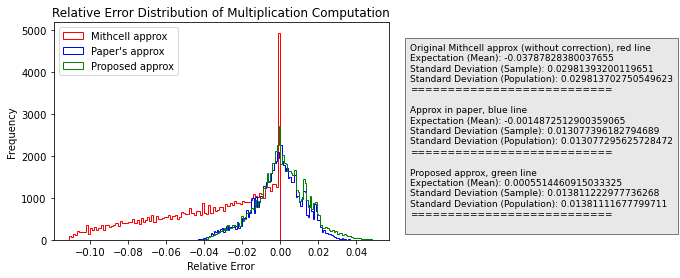

In [153]:
# Plot error distribution for mul
plt.hist(error_mul_mitchell, bins=100, edgecolor='red', histtype='step', label='Mithcell approx')
plt.hist(error_mul_paper, bins=100, edgecolor='blue', histtype='step',label="Paper's approx")
plt.hist(error_mul_proposed, bins=100, edgecolor='green', histtype='step', label='Proposed approx')

plt.xlabel('Relative Error')
plt.ylabel('Frequency')
plt.title('Relative Error Distribution of Multiplication Computation')

stats_lines = []

stats_lines.append("Original Mithcell approx (without correction), red line")
mean_value = np.mean(error_mul_mitchell)
std_dev_sample = np.std(error_mul_mitchell, ddof=1)
std_dev_population = np.std(error_mul_mitchell, ddof=0)
stats_lines.append(f"Expectation (Mean): {mean_value}")
stats_lines.append(f"Standard Deviation (Sample): {std_dev_sample}")
stats_lines.append(f"Standard Deviation (Population): {std_dev_population}")
stats_lines.append("===========================\n")

stats_lines.append("Approx in paper, blue line")
mean_value = np.mean(error_mul_paper)
std_dev_sample = np.std(error_mul_paper, ddof=1)
std_dev_population = np.std(error_mul_paper, ddof=0)
stats_lines.append(f"Expectation (Mean): {mean_value}")
stats_lines.append(f"Standard Deviation (Sample): {std_dev_sample}")
stats_lines.append(f"Standard Deviation (Population): {std_dev_population}")
stats_lines.append("===========================\n")

stats_lines.append("Proposed approx, green line")
mean_value = np.mean(error_mul_proposed)
std_dev_sample = np.std(error_mul_proposed, ddof=1)
std_dev_population = np.std(error_mul_proposed, ddof=0)
stats_lines.append(f"Expectation (Mean): {mean_value}")
stats_lines.append(f"Standard Deviation (Sample): {std_dev_sample}")
stats_lines.append(f"Standard Deviation (Population): {std_dev_population}")

stats_lines.append("===========================\n")
plt.legend(loc="upper left")
stats_text = "\n".join(stats_lines)
plt.figtext(0.95, 0.17, stats_text, ha="left", fontsize=9, bbox={"facecolor": "lightgray", "alpha": 0.5, "pad": 5})
plt.savefig(fig_path+"CompareRelativeMulError.png", format="png", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()

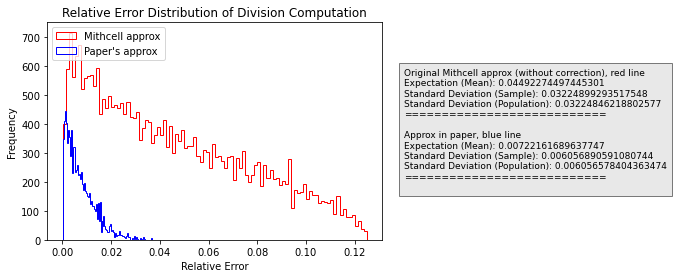

In [154]:
# Plot error distribution for div
# Remove all point in1 < in2
error_div_mitchell = [x for x in error_div_mitchell if x > 0]
error_div_paper = [x for x in error_div_paper if x > 0]

plt.hist(error_div_mitchell, bins=100, edgecolor='red', histtype='step', label='Mithcell approx')
plt.hist(error_div_paper, bins=100, edgecolor='blue', histtype='step',label="Paper's approx")

plt.xlabel('Relative Error')
plt.ylabel('Frequency')
plt.title('Relative Error Distribution of Division Computation')

stats_lines = []

stats_lines.append("Original Mithcell approx (without correction), red line")
mean_value = np.mean(error_div_mitchell)
std_dev_sample = np.std(error_div_mitchell, ddof=1)
std_dev_population = np.std(error_div_mitchell, ddof=0)
stats_lines.append(f"Expectation (Mean): {mean_value}")
stats_lines.append(f"Standard Deviation (Sample): {std_dev_sample}")
stats_lines.append(f"Standard Deviation (Population): {std_dev_population}")
stats_lines.append("===========================\n")

stats_lines.append("Approx in paper, blue line")
mean_value = np.mean(error_div_paper)
std_dev_sample = np.std(error_div_paper, ddof=1)
std_dev_population = np.std(error_div_paper, ddof=0)
stats_lines.append(f"Expectation (Mean): {mean_value}")
stats_lines.append(f"Standard Deviation (Sample): {std_dev_sample}")
stats_lines.append(f"Standard Deviation (Population): {std_dev_population}")
stats_lines.append("===========================\n")

plt.legend(loc="upper left")
stats_text = "\n".join(stats_lines)
plt.figtext(0.95, 0.3, stats_text, ha="left", fontsize=9, bbox={"facecolor": "lightgray", "alpha": 0.5, "pad": 5})
plt.savefig(fig_path+"CompareRelativeDivError.png", format="png", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()

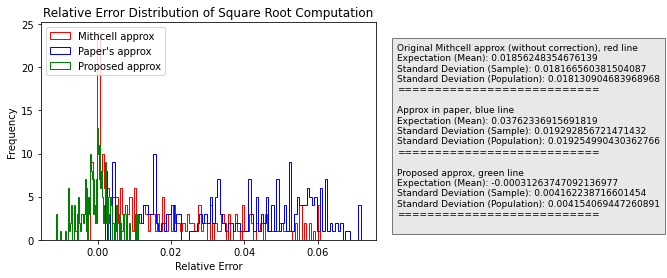

In [155]:
# Plot error distribution for root
plt.hist(error_root_mitchell, bins=100, edgecolor='red', histtype='step', label='Mithcell approx')
plt.hist(error_root_paper, bins=100, edgecolor='blue', histtype='step',label="Paper's approx")
plt.hist(error_root_proposed, bins=100, edgecolor='green', histtype='step', label='Proposed approx')

plt.xlabel('Relative Error')
plt.ylabel('Frequency')
plt.title('Relative Error Distribution of Square Root Computation')

stats_lines = []

stats_lines.append("Original Mithcell approx (without correction), red line")
mean_value = np.mean(error_root_mitchell)
std_dev_sample = np.std(error_root_mitchell, ddof=1)
std_dev_population = np.std(error_root_mitchell, ddof=0)
stats_lines.append(f"Expectation (Mean): {mean_value}")
stats_lines.append(f"Standard Deviation (Sample): {std_dev_sample}")
stats_lines.append(f"Standard Deviation (Population): {std_dev_population}")
stats_lines.append("===========================\n")

stats_lines.append("Approx in paper, blue line")
mean_value = np.mean(error_root_paper)
std_dev_sample = np.std(error_root_paper, ddof=1)
std_dev_population = np.std(error_root_paper, ddof=0)
stats_lines.append(f"Expectation (Mean): {mean_value}")
stats_lines.append(f"Standard Deviation (Sample): {std_dev_sample}")
stats_lines.append(f"Standard Deviation (Population): {std_dev_population}")
stats_lines.append("===========================\n")

stats_lines.append("Proposed approx, green line")
mean_value = np.mean(error_root_proposed)
std_dev_sample = np.std(error_root_proposed, ddof=1)
std_dev_population = np.std(error_root_proposed, ddof=0)
stats_lines.append(f"Expectation (Mean): {mean_value}")
stats_lines.append(f"Standard Deviation (Sample): {std_dev_sample}")
stats_lines.append(f"Standard Deviation (Population): {std_dev_population}")

stats_lines.append("===========================\n")
plt.legend(loc="upper left")
stats_text = "\n".join(stats_lines)
plt.figtext(0.95, 0.17, stats_text, ha="left", fontsize=9, bbox={"facecolor": "lightgray", "alpha": 0.5, "pad": 5})
plt.savefig(fig_path+"CompareRelativeRootError.png", format="png", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()

# Quick convert: FP -> Fixed point
Used to copy to the LUT HDL code

In [158]:
import numpy as np

def float_to_fixedpoint(f, bits_fractional):
    """Converts a floating point number to fixed point format with specified fractional bits."""
    fixed_point_value = int(f * (2 ** bits_fractional))
    return fixed_point_value

def generate_LUT(input_file, output_file, bits_fractional, num_segment):
    cnt = 0
    segment_width = int(np.log2(num_segment))
    with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
        for line in infile:
            line = line.strip()
            if line:
                try:
                    num = float(line)
                    if num < 1:
                        fixed_point = float_to_fixedpoint(num, bits_fractional)
                        binary_representation = format(fixed_point, f'0{bits_fractional}b')
                        cnt_representation = format(cnt, f'0{segment_width}b')
                        outfile.write(f'when "{cnt_representation}" => correction_term <= "{binary_representation}";\n')
                        cnt = cnt+1
                        if cnt == num_segment:
                          cnt = 0
                          zero_representation = format(0, f'0{bits_fractional}b')
                          outfile.write(f'when others => correction_term <= "{zero_representation}";\n\n')
                    else:
                        print(f"Warning: Value {num} exceeds range (>= 1). Check again.")
                except ValueError:
                    print(f"Warning: Invalid number '{line}' in the input file. Skipping.")

In [175]:
bits_fractional = 63
NUM_SEGMENT = 2
CorrTermDir = 'CorrectionTableLog'
input_file = f'{CorrTermDir}/log_{NUM_SEGMENT}s.txt'
output_file = f'{CorrTermDir}/bin_{NUM_SEGMENT}s_{bits_fractional+1}b.txt'

root_correction_pd = generate_root_pd_new(NUM_SEGMENT)

with open(input_file, 'w') as f:
    for value in root_correction_pd.values.flatten():
        f.write(f"{value}\n")
        
num_segment = 2**NUM_SEGMENT
generate_LUT(input_file, output_file, bits_fractional, num_segment)

# Verify HW result

In [411]:
!unzip -q HDL/SquareRoot/Sim/output_results_full.zip HDL/SquareRoot/Sim

 Length   Method    Size  Cmpr    Date    Time   CRC-32   Name
--------  ------  ------- ---- ---------- ----- --------  ----
--------          -------  ---                            -------
       0                0   0%                            0 files


In [367]:
NUM_SEGMENT = 2
WIDTH = 8

## Fixed point output

In [293]:
sim_out_dir = 'HDL/SquareRoot/Sim'
fig_dir = 'Figure/Hardware_Results/FixedPointOut'

In [294]:
if (WIDTH < 17):
  with open(f'{sim_out_dir}/output_results_{NUM_SEGMENT}s_{WIDTH}b_fix.txt', 'r') as file:
      results = [int(line.strip(), 2)/(2**(WIDTH - 1)) for line in file.readlines()]
  golden_res = [sqrt(x) for x in range(2**WIDTH)]

  relative_errors_hw = [(results[i] - golden_res[i]) / golden_res[i] for i in range(1, 2**WIDTH)]
  abs_errors_hw = [(results[i] - golden_res[i]) for i in range(1, 2**WIDTH)]

  if (golden_res[0] - results[0] == 0):
    relative_errors_hw.insert(0, 0) #For case golden_res = 0
    abs_errors_hw.insert(0, 0)
else:
  with open(f'{sim_out_dir}/output_results_{NUM_SEGMENT}s_{WIDTH}b_fix.txt', 'r') as file:
      results = [int(line.strip(), 2)/(2**(WIDTH - 1)) for line in file.readlines()]
  golden_res = [sqrt(x) for x in range(2**22)]

  relative_errors_hw = [(results[i] - golden_res[i]) / golden_res[i] for i in range(1, 2**22)]
  abs_errors_hw = [(results[i] - golden_res[i]) for i in range(1, 2**22)]

  if (golden_res[0] - results[0] == 0):
    relative_errors_hw.insert(0, 0) #For case golden_res = 0
    abs_errors_hw.insert(0, 0)

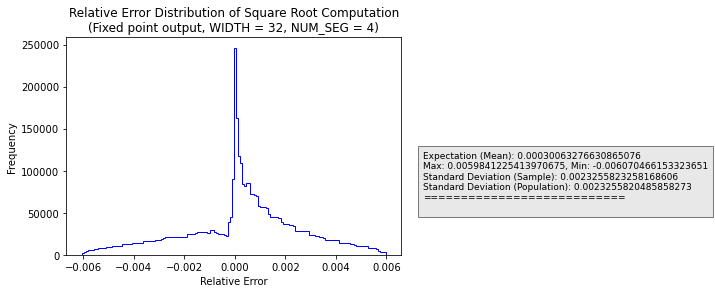

In [295]:
#Plot error distribution
plt.hist(relative_errors_hw, bins=150, edgecolor='blue', histtype='step')
plt.xlabel('Relative Error')
plt.ylabel('Frequency')
plt.title(f'Relative Error Distribution of Square Root Computation\n(Fixed point output, WIDTH = {WIDTH}, NUM_SEG = {NUM_SEGMENT})')

stats_lines = []
mean_value = np.mean(relative_errors_hw)
std_dev_sample = np.std(relative_errors_hw, ddof=1)
std_dev_population = np.std(relative_errors_hw, ddof=0)
stats_lines.append(f"Expectation (Mean): {mean_value}")
stats_lines.append(f"Max: {np.max(relative_errors_hw)}, Min: {np.min(relative_errors_hw)}")
stats_lines.append(f"Standard Deviation (Sample): {std_dev_sample}")
stats_lines.append(f"Standard Deviation (Population): {std_dev_population}")
stats_lines.append("===========================\n")

stats_text = "\n".join(stats_lines)
plt.figtext(0.95, 0.28, stats_text, ha="left", fontsize=9, bbox={"facecolor": "lightgray", "alpha": 0.5, "pad": 5})
plt.savefig(f"{fig_dir}/RelativeErr_Distribution_{WIDTH}b_{NUM_SEGMENT}s.png", format="png", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()

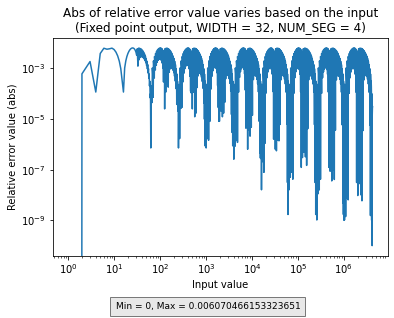

In [296]:
# Plot abs(relative error) vs input
relative_errors_hw_abs = [abs(x) for x in relative_errors_hw]
plt.plot(range(len(relative_errors_hw_abs)), relative_errors_hw_abs)

plt.xscale("log")
plt.yscale("log")
plt.xlabel('Input value')
plt.ylabel('Relative error value (abs)')
plt.title(f'Abs of relative error value varies based on the input\n(Fixed point output, WIDTH = {WIDTH}, NUM_SEG = {NUM_SEGMENT})')

stats_text = f"Min = {min(relative_errors_hw_abs)}, Max = {max(relative_errors_hw_abs)}"
plt.figtext(0.27, -0.06, stats_text, ha="left", fontsize=9, bbox={"facecolor": "lightgray", "alpha": 0.5, "pad": 5})

plt.savefig(f"{fig_dir}/AbsRelativeErrvsInput_{WIDTH}b_{NUM_SEGMENT}s.png", format="png", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()

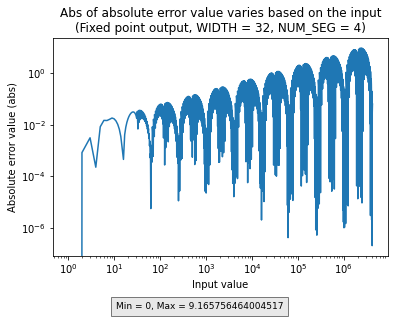

In [297]:
# Plot abs(absolute error) vs input
abs_errors_hw_abs = [abs(x) for x in abs_errors_hw]
plt.plot(range(len(abs_errors_hw_abs)), abs_errors_hw_abs)

plt.xscale("log")
plt.yscale("log")
plt.xlabel('Input value')
plt.ylabel('Absolute error value (abs)')
plt.title(f'Abs of absolute error value varies based on the input\n(Fixed point output, WIDTH = {WIDTH}, NUM_SEG = {NUM_SEGMENT})')

stats_text = f"Min = {min(abs_errors_hw_abs)}, Max = {max(abs_errors_hw_abs)}"
plt.figtext(0.27, -0.06, stats_text, ha="left", fontsize=9, bbox={"facecolor": "lightgray", "alpha": 0.5, "pad": 5})

plt.savefig(f"{fig_dir}/AbsAbsoluteErrvsInput_{WIDTH}b_{NUM_SEGMENT}s.png", format="png", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()

## Int output

In [368]:
sim_out_dir = 'HDL/SquareRoot/Sim'
fig_dir = 'Figure/Hardware_Results/IntOut'

In [369]:
if (WIDTH < 17):
  with open(f'{sim_out_dir}/output_results_{NUM_SEGMENT}s_{WIDTH}b_int.txt', 'r') as file:
      results = [int(line.strip(), 2) for line in file.readlines()]
  golden_res = [sqrt(x) for x in range(2**WIDTH)]

  relative_errors_int_hw = [(results[i] - golden_res[i]) / golden_res[i] for i in range(1, 2**WIDTH)]
  abs_errors_int_hw = [(results[i] - golden_res[i]) for i in range(1, 2**WIDTH)]

  if (golden_res[0] - results[0] == 0):
    relative_errors_int_hw.insert(0, 0) #For case golden_res = 0
    abs_errors_int_hw.insert(0, 0)
else:
  with open(f'{sim_out_dir}/output_results_{NUM_SEGMENT}s_{WIDTH}b_int.txt', 'r') as file:
      results = [int(line.strip(), 2) for line in file.readlines()]
  golden_res = [sqrt(x) for x in range(2**22)]

  relative_errors_int_hw = [(results[i] - golden_res[i]) / golden_res[i] for i in range(1, 2**22)]
  abs_errors_int_hw = [(results[i] - golden_res[i]) for i in range(1, 2**22)]

  if (golden_res[0] - results[0] == 0):
    relative_errors_int_hw.insert(0, 0) #For case golden_res = 0
    abs_errors_int_hw.insert(0, 0)

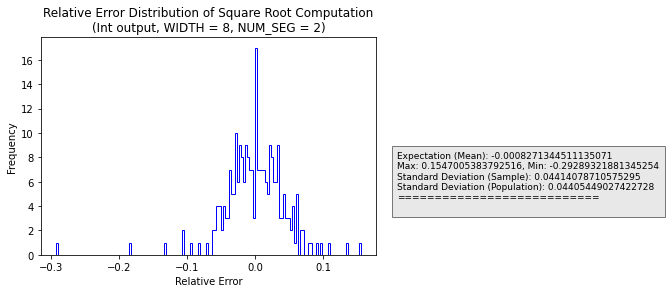

In [370]:
#Plot error distribution
plt.hist(relative_errors_int_hw, bins=150, edgecolor='blue', histtype='step')
plt.xlabel('Relative Error')
plt.ylabel('Frequency')
plt.title(f'Relative Error Distribution of Square Root Computation\n(Int output, WIDTH = {WIDTH}, NUM_SEG = {NUM_SEGMENT})')

stats_lines = []
mean_value = np.mean(relative_errors_int_hw)
std_dev_sample = np.std(relative_errors_int_hw, ddof=1)
std_dev_population = np.std(relative_errors_int_hw, ddof=0)
stats_lines.append(f"Expectation (Mean): {mean_value}")
stats_lines.append(f"Max: {np.max(relative_errors_int_hw)}, Min: {np.min(relative_errors_int_hw)}")
stats_lines.append(f"Standard Deviation (Sample): {std_dev_sample}")
stats_lines.append(f"Standard Deviation (Population): {std_dev_population}")
stats_lines.append("===========================\n")

stats_text = "\n".join(stats_lines)
plt.figtext(0.95, 0.28, stats_text, ha="left", fontsize=9, bbox={"facecolor": "lightgray", "alpha": 0.5, "pad": 5})
plt.savefig(f"{fig_dir}/RelativeErr_Distribution_{WIDTH}b_{NUM_SEGMENT}s.png", format="png", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()

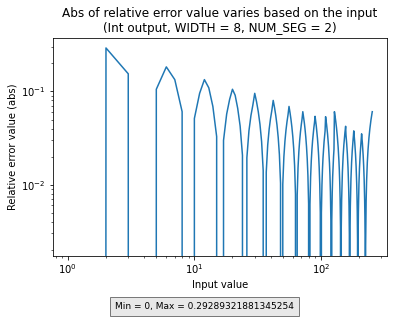

In [371]:
# Plot abs(relative error) vs input
relative_errors_int_hw_abs = [abs(x) for x in relative_errors_int_hw]
plt.plot(range(len(relative_errors_int_hw_abs)), relative_errors_int_hw_abs)

plt.xscale("log")
plt.yscale("log")
plt.xlabel('Input value')
plt.ylabel('Relative error value (abs)')
plt.title(f'Abs of relative error value varies based on the input\n(Int output, WIDTH = {WIDTH}, NUM_SEG = {NUM_SEGMENT})')

stats_text = f"Min = {min(relative_errors_int_hw_abs)}, Max = {max(relative_errors_int_hw_abs)}"
plt.figtext(0.27, -0.06, stats_text, ha="left", fontsize=9, bbox={"facecolor": "lightgray", "alpha": 0.5, "pad": 5})

plt.savefig(f"{fig_dir}/AbsRelativeErrvsInput_{WIDTH}b_{NUM_SEGMENT}s.png", format="png", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()

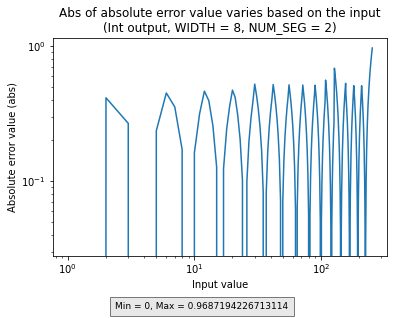

In [372]:
# Plot abs(absolute error) vs input
abs_errors_int_hw_abs = [abs(x) for x in abs_errors_int_hw]
plt.plot(range(len(abs_errors_int_hw_abs)), abs_errors_int_hw_abs)

plt.xscale("log")
plt.yscale("log")
plt.xlabel('Input value')
plt.ylabel('Absolute error value (abs)')
plt.title(f'Abs of absolute error value varies based on the input\n(Int output, WIDTH = {WIDTH}, NUM_SEG = {NUM_SEGMENT})')

stats_text = f"Min = {min(abs_errors_int_hw_abs)}, Max = {max(abs_errors_int_hw_abs)}"
plt.figtext(0.27, -0.06, stats_text, ha="left", fontsize=9, bbox={"facecolor": "lightgray", "alpha": 0.5, "pad": 5})

plt.savefig(f"{fig_dir}/AbsAbsoluteErrvsInput_{WIDTH}b_{NUM_SEGMENT}s.png", format="png", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()

## Old architecture (int out)

In [319]:
sim_out_dir = 'HDL'
fig_dir = 'Figure/Hardware_Results/OldArch'

In [320]:
with open(f'{sim_out_dir}/output_results_oldarch_32b_int.txt', 'r') as file:
    results = [int(line.strip(), 2) for line in file.readlines()]
golden_res = [sqrt(x) for x in range(2**22)]

relative_errors_int_oldarch = [(results[i] - golden_res[i]) / golden_res[i] for i in range(1, 2**22)]
abs_errors_int_oldarch = [(results[i] - golden_res[i]) for i in range(1, 2**22)]

if (golden_res[0] - results[0] == 0):
  relative_errors_int_oldarch.insert(0, 0) #For case golden_res = 0
  abs_errors_int_oldarch.insert(0, 0)

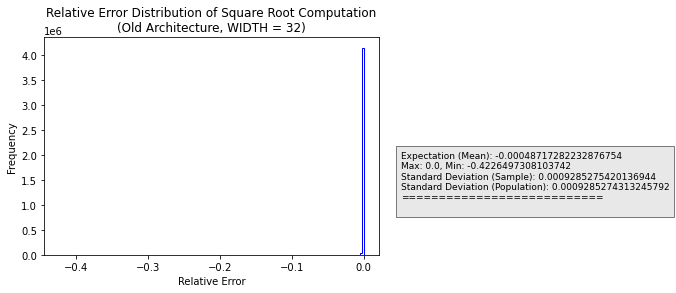

In [322]:
#Plot error distribution
plt.hist(relative_errors_int_oldarch, bins=150, edgecolor='blue', histtype='step')
plt.xlabel('Relative Error')
plt.ylabel('Frequency')
plt.title(f'Relative Error Distribution of Square Root Computation\n(Old Architecture, WIDTH = {WIDTH})')

stats_lines = []
mean_value = np.mean(relative_errors_int_oldarch)
std_dev_sample = np.std(relative_errors_int_oldarch, ddof=1)
std_dev_population = np.std(relative_errors_int_oldarch, ddof=0)
stats_lines.append(f"Expectation (Mean): {mean_value}")
stats_lines.append(f"Max: {np.max(relative_errors_int_oldarch)}, Min: {np.min(relative_errors_int_oldarch)}")
stats_lines.append(f"Standard Deviation (Sample): {std_dev_sample}")
stats_lines.append(f"Standard Deviation (Population): {std_dev_population}")
stats_lines.append("===========================\n")

stats_text = "\n".join(stats_lines)
plt.figtext(0.95, 0.28, stats_text, ha="left", fontsize=9, bbox={"facecolor": "lightgray", "alpha": 0.5, "pad": 5})
plt.savefig(f"{fig_dir}/RelativeErr_Distribution_OldArch_32b.png", format="png", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()

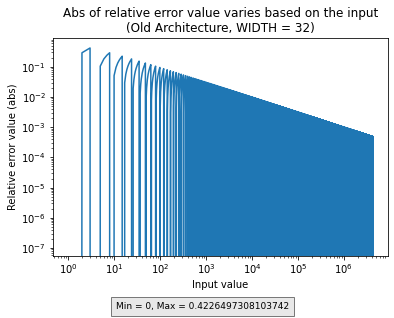

In [323]:
# Plot abs(relative error) vs input
relative_errors_int_oldarch_abs = [abs(x) for x in relative_errors_int_oldarch]
plt.plot(range(len(relative_errors_int_oldarch_abs)), relative_errors_int_oldarch_abs)

plt.xscale("log")
plt.yscale("log")
plt.xlabel('Input value')
plt.ylabel('Relative error value (abs)')
plt.title(f'Abs of relative error value varies based on the input\n(Old Architecture, WIDTH = {WIDTH})')

stats_text = f"Min = {min(relative_errors_int_oldarch_abs)}, Max = {max(relative_errors_int_oldarch_abs)}"
plt.figtext(0.27, -0.06, stats_text, ha="left", fontsize=9, bbox={"facecolor": "lightgray", "alpha": 0.5, "pad": 5})

plt.savefig(f"{fig_dir}/AbsRelativeErrvsInput_OldArch_32b.png", format="png", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()

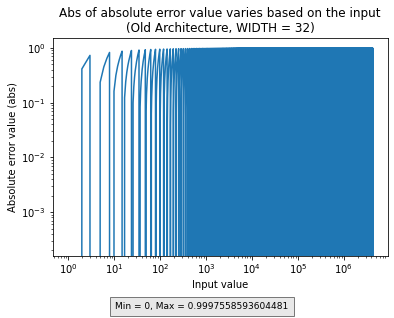

In [324]:
# Plot abs(absolute error) vs input
abs_errors_int_oldarch_abs = [abs(x) for x in abs_errors_int_oldarch]
plt.plot(range(len(abs_errors_int_oldarch_abs)), abs_errors_int_oldarch_abs)

plt.xscale("log")
plt.yscale("log")
plt.xlabel('Input value')
plt.ylabel('Absolute error value (abs)')
plt.title(f'Abs of absolute error value varies based on the input\n(Old Architecture, WIDTH = {WIDTH})')

stats_text = f"Min = {min(abs_errors_int_oldarch_abs)}, Max = {max(abs_errors_int_oldarch_abs)}"
plt.figtext(0.27, -0.06, stats_text, ha="left", fontsize=9, bbox={"facecolor": "lightgray", "alpha": 0.5, "pad": 5})

plt.savefig(f"{fig_dir}/AbsAbsoluteErrvsInput_OldArch_32b.png", format="png", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()

# New approx method

In [404]:
SEG_NUM = 64

## Util function

In [405]:
import numpy as np
import matplotlib.pyplot as plt

def evaluate_apprx(error):
  rms_error = np.sqrt(np.mean(error**2))
  mean_error = np.mean(error)
  std_error = np.std(error)
  return [rms_error, mean_error, std_error]

# Try multiple apprx
def find_approx(power_list, x, y_ideal):
  approximations = []
  for A in power_list:
      for B in power_list:
          y_approx = A * x + B
          error = y_approx - y_ideal
          rms, mean, std = evaluate_apprx(error)

          # Store the results along with the parameters A and B
          approximations.append({'A': A, 'B': B, 'rms': rms, 'mean': mean, 'std': std, 'approx_func': f'y = {A}*x + {B}'})
  # Sort Approximation with lowest RMS
  best_approx = sorted(approximations, key=lambda x: x['rms'])[0]
  # Print results
  print(f"{best_approx['approx_func']} (RMS: {best_approx['rms']:.6f})")
  return best_approx

def find_all_approx(SEG_NUM):
  print(f"Using {SEG_NUM} segments to approx log2(x+1)")

  inter = [x/SEG_NUM for x in range(1,SEG_NUM+1)]
  inter.insert(0,0.0001)

  approximations = []
  x_all = np.array([])
  ideal_y = np.array([])
  approx_y = np.array([])
  for i in range(SEG_NUM):
    print(f"\nSegment {i+1}: [{inter[i]}, {inter[i+1]})")
    x = np.linspace(inter[i], inter[i+1], 10000)
    y_log2 = np.log2(x + 1)

    current_approx = find_approx(power_list, x, y_log2)
    A = current_approx['A']
    B = current_approx['B']
    y_approx = A * x + B

    approximations.append(current_approx)
    x_all = np.concatenate((x_all, x))
    ideal_y = np.concatenate((ideal_y, y_log2))
    approx_y = np.concatenate((approx_y, y_approx))
    i=i+1

  error = approx_y - ideal_y
  return [approximations, x_all, ideal_y, approx_y, error]

## Plot result

In [406]:
MIN_POWER = -8
MAX_POWER = 8
power_list = [2**i for i in range(MIN_POWER, MAX_POWER)]
power_list.append(0)

approximations, x_all, ideal_y, approx_y, error = find_all_approx(SEG_NUM)

Using 128 segments to approx log2(x+1)

Segment 1: [0.0001, 0.0078125)
y = 1*x + 0 (RMS: 0.001991)

Segment 2: [0.0078125, 0.015625)
y = 1*x + 0.00390625 (RMS: 0.001521)

Segment 3: [0.015625, 0.0234375)
y = 1*x + 0.0078125 (RMS: 0.001090)

Segment 4: [0.0234375, 0.03125)
y = 0.25*x + 0.03125 (RMS: 0.002732)

Segment 5: [0.03125, 0.0390625)
y = 1*x + 0.015625 (RMS: 0.001290)

Segment 6: [0.0390625, 0.046875)
y = 1*x + 0.015625 (RMS: 0.002270)

Segment 7: [0.046875, 0.0546875)
y = 0.125*x + 0.0625 (RMS: 0.003840)

Segment 8: [0.0546875, 0.0625)
y = 0.25*x + 0.0625 (RMS: 0.005592)

Segment 9: [0.0625, 0.0703125)
y = 0.5*x + 0.0625 (RMS: 0.003521)

Segment 10: [0.0703125, 0.078125)
y = 1*x + 0.03125 (RMS: 0.002317)

Segment 11: [0.078125, 0.0859375)
y = 1*x + 0.03125 (RMS: 0.000880)

Segment 12: [0.0859375, 0.09375)
y = 1*x + 0.03125 (RMS: 0.003111)

Segment 13: [0.09375, 0.1015625)
y = 0.125*x + 0.125 (RMS: 0.003866)

Segment 14: [0.1015625, 0.109375)
y = 0.125*x + 0.125 (RMS: 0.006998)


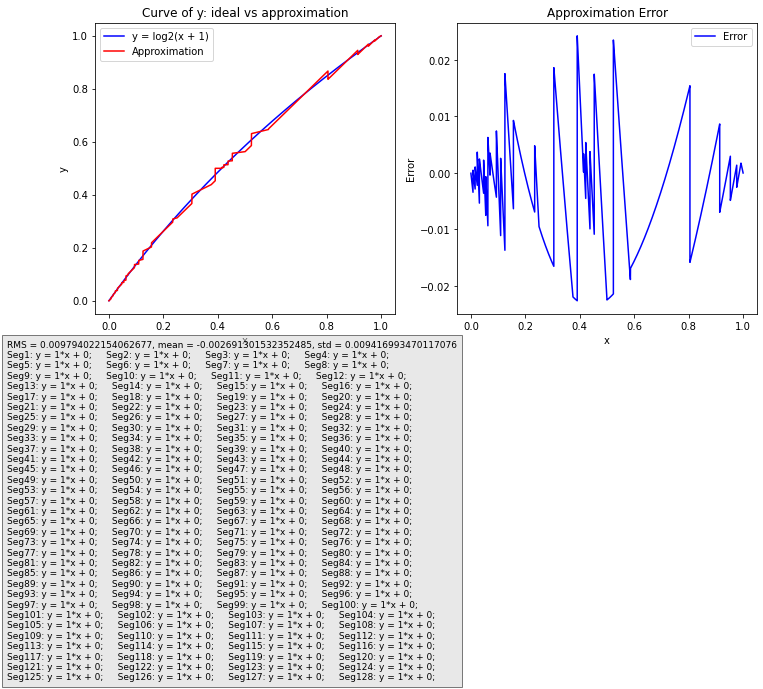

In [407]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(x_all, ideal_y, label='y = log2(x + 1)', color='blue')
plt.plot(x_all, approx_y, label='Approximation', color='red')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Curve of y: ideal vs approximation')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(x_all, error, label='Error', color='blue')
plt.xlabel('x')
plt.ylabel('Error')
plt.title('Approximation Error')
plt.legend()

plt.tight_layout()

rms_error, mean_error, std_error = evaluate_apprx(error)
stats_text = f"RMS = {rms_error}, mean = {mean_error}, std = {std_error}\n"
for i in range(SEG_NUM):
    stats_text += f"Seg{i+1}: {approximations[0]['approx_func']};     "
    if (i%4==3) and i != (SEG_NUM - 1):
        stats_text += "\n"

plt.figtext(0.2 - SEG_NUM/500, -0.1 - SEG_NUM/160, stats_text, ha="left", fontsize=9, bbox={"facecolor": "lightgray", "alpha": 0.5, "pad": 5})

plt.savefig(f"Figure/New_Approx/Approximate_{SEG_NUM}_seg.png", format="png", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()